In [35]:
import numpy as np
import pandas as pd
from keras.datasets import mnist #mnist 데이터셋
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout
from matplotlib import pyplot as plt # 학습 과정 loss와 acc 시각화
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

- Red Wine 등급 예측
1. 데이터 셋 확보
    csv -> 결측치 처리 -> 독립변수와 종속변수 분리 -> 독립변수 스케일조정 -> 종속변수의 원핫인코딩 -> 훈련셋과 테스트셋 분리
2. 모델 구성(입력11, 출력6-pd.getdummies | 출력9-tto_categorical) layer층 4
3. 모델 학습 과정 설정
4. 모델 학습(callback)
5. 모델 평가(그래프, 평가, 교차표)
6. 모델 저장 & 사용

# 1. 데이터 확보 및 전처리

In [138]:
# 데이터 읽어오기
redwine = pd.read_csv('data/winequality-red.csv', sep=';')
redwine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [ ]:
# 각 등급의 데이터를 10개씩만 사용하기에는 너무 부족해진다
g = []
for i in range(3,9):
    g.append(redwine[redwine['quality']==i].sample(10))
np.array(g).reshape(60,12)

array([[7.1000e+00, 8.7500e-01, 5.0000e-02, 5.7000e+00, 8.2000e-02,
        3.0000e+00, 1.4000e+01, 9.9808e-01, 3.4000e+00, 5.2000e-01,
        1.0200e+01, 3.0000e+00],
       [7.6000e+00, 1.5800e+00, 0.0000e+00, 2.1000e+00, 1.3700e-01,
        5.0000e+00, 9.0000e+00, 9.9476e-01, 3.5000e+00, 4.0000e-01,
        1.0900e+01, 3.0000e+00],
       [1.0400e+01, 6.1000e-01, 4.9000e-01, 2.1000e+00, 2.0000e-01,
        5.0000e+00, 1.6000e+01, 9.9940e-01, 3.1600e+00, 6.3000e-01,
        8.4000e+00, 3.0000e+00],
       [6.7000e+00, 7.6000e-01, 2.0000e-02, 1.8000e+00, 7.8000e-02,
        6.0000e+00, 1.2000e+01, 9.9600e-01, 3.5500e+00, 6.3000e-01,
        9.9500e+00, 3.0000e+00],
       [7.4000e+00, 1.1850e+00, 0.0000e+00, 4.2500e+00, 9.7000e-02,
        5.0000e+00, 1.4000e+01, 9.9660e-01, 3.6300e+00, 5.4000e-01,
        1.0700e+01, 3.0000e+00],
       [1.0400e+01, 4.4000e-01, 4.2000e-01, 1.5000e+00, 1.4500e-01,
        3.4000e+01, 4.8000e+01, 9.9832e-01, 3.3800e+00, 8.6000e-01,
        9.9000e+00,

In [140]:
# 독립변수와 종속 변수로 분할
dataset = np.array(redwine)
X = dataset[:,:-1]
y = dataset[:,-1]

In [141]:
# 독립변수 스케일링
scaler_X = MinMaxScaler()
scaled_X = scaler_X.fit_transform(X)
scaled_X

array([[0.24778761, 0.39726027, 0.        , ..., 0.60629921, 0.13772455,
        0.15384615],
       [0.28318584, 0.52054795, 0.        , ..., 0.36220472, 0.20958084,
        0.21538462],
       [0.28318584, 0.43835616, 0.04      , ..., 0.40944882, 0.19161677,
        0.21538462],
       ...,
       [0.15044248, 0.26712329, 0.13      , ..., 0.53543307, 0.25149701,
        0.4       ],
       [0.11504425, 0.35958904, 0.12      , ..., 0.65354331, 0.22754491,
        0.27692308],
       [0.12389381, 0.13013699, 0.47      , ..., 0.51181102, 0.19760479,
        0.4       ]])

In [142]:
# 종속변수 원핫인코딩
Y = to_categorical(y)
Y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [143]:
# 훈련 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(scaled_X, Y, 
                                   test_size=0.3, #테스트셋 비율 
                                   stratify=y)    # 층화추출
X_train.shape, X_test.shape, y_train.shape,  y_test.shape

((1119, 11), (480, 11), (1119, 9), (480, 9))

# 2. 모델 생성

In [151]:
# 모델 구성
model = Sequential()
model.add(Input(shape=(11,)))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=9, activation='softmax'))
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 64)                768       
                                                                 
 dropout_16 (Dropout)        (None, 64)                0         
                                                                 
 dense_57 (Dense)            (None, 128)               8320      
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 dense_58 (Dense)            (None, 32)                4128      
                                                                 
 dense_59 (Dense)            (None, 9)                 297       
                                                                 
Total params: 13,513
Trainable params: 13,513
Non-tra

In [152]:
# 모델 학습 과정 설정
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [153]:
# 모델 학습
file = 'model09/wine-{epoch:03d}-val{val_accuracy:.4f}.h5'
checkpoint = ModelCheckpoint(filepath=file,  monitor='val_accuracy', save_best_only=True,  mode = 'max')
early_stopping = EarlyStopping(monitor='val_loss', patience=60)

hist = model.fit(X_train, y_train, epochs=500, validation_split=0.1, verbose=1, batch_size=2000, callbacks=[early_stopping,checkpoint])

Epoch 1/500
1/1 [==============================] - 1s 718ms/step - loss: 2.2207 - accuracy: 0.0189 - val_loss: 2.1896 - val_accuracy: 0.0804
Epoch 2/500
1/1 [==============================] - 0s 61ms/step - loss: 2.1916 - accuracy: 0.0705 - val_loss: 2.1604 - val_accuracy: 0.1250
Epoch 3/500
1/1 [==============================] - 0s 61ms/step - loss: 2.1619 - accuracy: 0.1500 - val_loss: 2.1325 - val_accuracy: 0.3125
Epoch 4/500
1/1 [==============================] - 0s 65ms/step - loss: 2.1354 - accuracy: 0.2681 - val_loss: 2.1054 - val_accuracy: 0.4375
Epoch 5/500
1/1 [==============================] - 0s 69ms/step - loss: 2.1073 - accuracy: 0.3496 - val_loss: 2.0793 - val_accuracy: 0.4554
Epoch 6/500
1/1 [==============================] - 0s 42ms/step - loss: 2.0817 - accuracy: 0.3942 - val_loss: 2.0540 - val_accuracy: 0.4375
Epoch 7/500
1/1 [==============================] - 0s 42ms/step - loss: 2.0592 - accuracy: 0.3982 - val_loss: 2.0291 - val_accuracy: 0.4554
Epoch 8/500
1/1 [==

# 3. 모델 평가

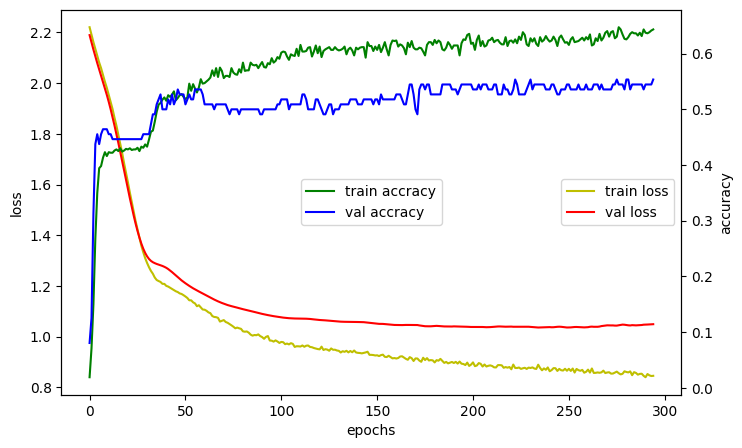

In [157]:
fig, loss_ax = plt.subplots(figsize=(8,5))
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
acc_ax =loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'g', label='train accracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val accracy')
loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc = 'center right')
acc_ax.legend(loc = 'center')


In [158]:
loss, acc = model.evaluate(X_test, y_test)
print('오차 : {:.3f}, 정확도 : {:.3f}'.format(loss,acc))

15/15 [==============================] - 0s 2ms/step - loss: 0.9183 - accuracy: 0.6104
오차 : 0.918, 정확도 : 0.610


In [159]:
y_hat = model.predict(X_test).argmax(axis=1)
ctab = pd.crosstab(y_test.argmax(axis=1), y_hat)
ctab

15/15 [==============================] - 0s 1ms/step


col_0,4,5,6,7
row_0,,,,
3,1,2,0,0
4,0,12,3,1
5,2,151,49,2
6,0,57,119,16
7,0,6,31,23
8,0,0,2,3
